In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import pandas as pd
import numpy as np

# Paths to the files in Google Drive
train_data_path = '/content/drive/My Drive/Train_data.csv'
test_data_path = '/content/drive/My Drive/Test_data.csv'
val_data_path = '/content/drive/My Drive/Val_data.csv'

# Load the CSV files
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
val_data = pd.read_csv(val_data_path)

train_metadata_path = '/content/drive/My Drive/Train_metadata.npy'
test_metadata_path = '/content/drive/My Drive/Test_metadata.npy'
val_metadata_path = '/content/drive/My Drive/Val_metadata.npy'

train_metadata = np.load(train_metadata_path)
test_metadata = np.load(test_metadata_path)
val_metadata = np.load(val_metadata_path)

train_image_features_path = '/content/drive/My Drive/Train_image_features.npy'
test_image_features_path = '/content/drive/My Drive/Test_image_features.npy'
val_image_features_path = '/content/drive/My Drive/Val_image_features.npy'

train_image_features_array  = np.load(train_image_features_path)
test_image_features_array  = np.load(test_image_features_path)
val_image_features_array = np.load(val_image_features_path)

In [32]:
train_data.columns


Index(['Patient_ID', 'Age', 'Size_cm', 'Recurrence', 'Sex_F', 'Sex_M',
       'Polyp_Location_ Descending', 'Polyp_Location_ Sigmoid',
       'Polyp_Location_ Splenic Flexure', 'Polyp_Location_Anastomosis',
       'Polyp_Location_Asc / Transverse ?', 'Polyp_Location_Ascending',
       'Polyp_Location_Cecum', 'Polyp_Location_Cecum\nKissing Polyps',
       'Polyp_Location_Descending', 'Polyp_Location_Descending ',
       'Polyp_Location_Hepatic Flexure', 'Polyp_Location_Ileocecal Valve',
       'Polyp_Location_Ileocecal Valve\nKissing Polyps',
       'Polyp_Location_Rectosigmoid', 'Polyp_Location_Rectosigmoid ',
       'Polyp_Location_Rectum', 'Polyp_Location_Sigmoid',
       'Polyp_Location_Sigmoid, Splenic Flexure',
       'Polyp_Location_Splenic Flexure', 'Polyp_Location_Transvers Colon',
       'Polyp_Location_Transverse', 'Circum_0.3333333333333333', 'Circum_<1/3',
       'Circum_>1/3', 'Cross_Two_Folds_Between Folds', 'Cross_Two_Folds_Neg',
       'Cross_Two_Folds_On Fold', 'Cross_

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Training Accuracy for Pathology Model: 1.0
Training Accuracy for Morphology Model: 0.9777699364855328

Pathology Validation Metrics:
Accuracy: 1.0
Classification Report:
                                  precision    recall  f1-score   support

        Diagnosis_Adenocarcinoma       1.00      1.00      1.00        19
          Diagnosis_Hyperplastic       1.00      1.00      1.00       519
              Diagnosis_Serrated       1.00      1.00      1.00        21
Diagnosis_Serrated, Hyperplastic       1.00      1.00      1.00         1
                 Diagnosis_T + V       1.00      1.00      1.00       242
               Diagnosis_Tubular       1.00      1.00      1.00        68
               Diagnosis_Villous       1.00      1.00      1.00        74

                        accuracy                           1.00       944
                       macro avg       1.00      1.00      1.00       944
                    weighted avg       1.00      1.00      1.00       944


Morphology V

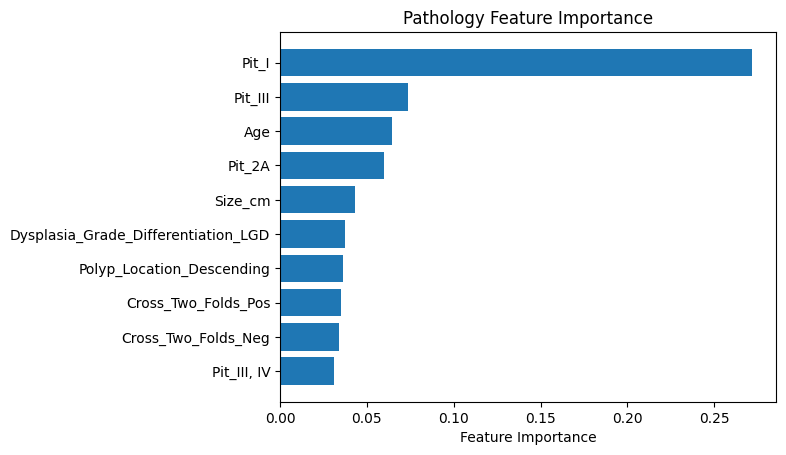

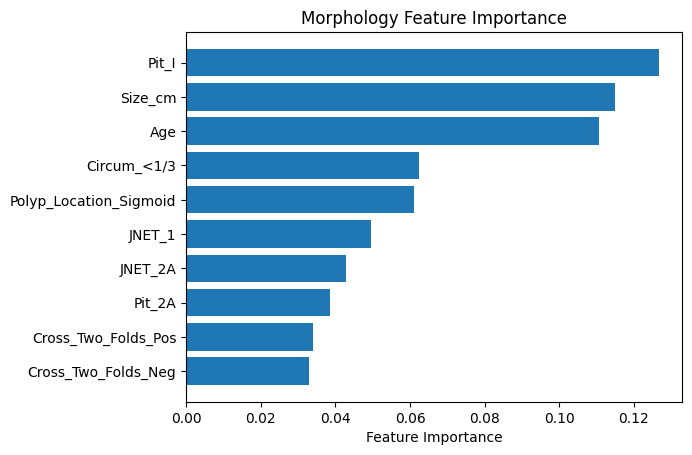

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Prepare the Data

# Extract all Diagnosis columns for Pathology classification
diagnosis_columns = [
    col for col in train_data.columns if col.startswith('Diagnosis_')
]

# Extract all Paris columns for Morphology classification
paris_columns = [
    col for col in train_data.columns if col.startswith('Paris_')
]

# Combine Diagnosis columns into a single target for pathology classification
train_data['Pathology_Target'] = train_data[diagnosis_columns].idxmax(axis=1)
test_data['Pathology_Target'] = test_data[diagnosis_columns].idxmax(axis=1)
val_data['Pathology_Target'] = val_data[diagnosis_columns].idxmax(axis=1)

# Combine Paris columns into a single target for morphology classification
train_data['Morphology_Target'] = train_data[paris_columns].idxmax(axis=1)
test_data['Morphology_Target'] = test_data[paris_columns].idxmax(axis=1)
val_data['Morphology_Target'] = val_data[paris_columns].idxmax(axis=1)

# Features for the model (excluding target columns, unrelated columns, and Patient_ID)
feature_columns = [
    col for col in train_data.columns if col not in
    (['Pathology_Target', 'Morphology_Target', 'File_Path', 'Split', 'Patient_ID', 'Recurrence'] + diagnosis_columns + paris_columns)
]

# Prepare feature sets and targets
X_train = train_data[feature_columns]
X_test = test_data[feature_columns]
X_val = val_data[feature_columns]

y_path_train = train_data['Pathology_Target']
y_path_test = test_data['Pathology_Target']
y_path_val = val_data['Pathology_Target']

y_morph_train = train_data['Morphology_Target']
y_morph_test = test_data['Morphology_Target']
y_morph_val = val_data['Morphology_Target']

# Step 2: Train the Models
# Pathology Classification Model
pathology_model = RandomForestClassifier(random_state=42)
pathology_model.fit(X_train, y_path_train)

# Morphology Classification Model
morphology_model = RandomForestClassifier(random_state=42)
morphology_model.fit(X_train, y_morph_train)

# Step 3: Evaluate the Models
# Training Accuracy
pathology_train_acc = pathology_model.score(X_train, y_path_train)
morphology_train_acc = morphology_model.score(X_train, y_morph_train)

print("Training Accuracy for Pathology Model:", pathology_train_acc)
print("Training Accuracy for Morphology Model:", morphology_train_acc)

# Step 4: Validate the Models on Validation Dataset
# Pathology Validation
y_path_val_pred = pathology_model.predict(X_val)
print("\nPathology Validation Metrics:")
print("Accuracy:", accuracy_score(y_path_val, y_path_val_pred))
print("Classification Report:")
print(classification_report(y_path_val, y_path_val_pred))

# Morphology Validation
y_morph_val_pred = morphology_model.predict(X_val)
print("\nMorphology Validation Metrics:")
print("Accuracy:", accuracy_score(y_morph_val, y_morph_val_pred))
print("Classification Report:")
print(classification_report(y_morph_val, y_morph_val_pred))

# Test Accuracy and Metrics
# Pathology Classification Evaluation
y_path_pred = pathology_model.predict(X_test)
print("\nPathology Classification Metrics (Test Data):")
print("Accuracy:", accuracy_score(y_path_test, y_path_pred))
print("Classification Report:")
print(classification_report(y_path_test, y_path_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_path_test, y_path_pred))

# Morphology Classification Evaluation
y_morph_pred = morphology_model.predict(X_test)
print("\nMorphology Classification Metrics (Test Data):")
print("Accuracy:", accuracy_score(y_morph_test, y_morph_pred))
print("Classification Report:")
print(classification_report(y_morph_test, y_morph_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_morph_test, y_morph_pred))

# Step 5: Feature Importance Analysis
import matplotlib.pyplot as plt

def plot_feature_importance(model, features, title):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    top_features = [features[i] for i in sorted_idx[:10]]
    top_importance = importance[sorted_idx[:10]]

    plt.barh(top_features, top_importance)
    plt.xlabel("Feature Importance")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Feature importance for pathology classification
plot_feature_importance(pathology_model, feature_columns, "Pathology Feature Importance")

# Feature importance for morphology classification
plot_feature_importance(morphology_model, feature_columns, "Morphology Feature Importance")


Training Accuracy for Pathology Model: 1.0
Training Accuracy for Morphology Model: 1.0

Pathology Classification Metrics (Test Data):
Accuracy: 0.9905163329820864
Classification Report:
                          precision    recall  f1-score   support

Diagnosis_Adenocarcinoma       1.00      0.92      0.96        24
  Diagnosis_Hyperplastic       1.00      1.00      1.00       491
      Diagnosis_Serrated       1.00      1.00      1.00        13
         Diagnosis_T + V       0.97      1.00      0.98       282
       Diagnosis_Tubular       1.00      0.89      0.94        62
       Diagnosis_Villous       1.00      1.00      1.00        77

                accuracy                           0.99       949
               macro avg       0.99      0.97      0.98       949
            weighted avg       0.99      0.99      0.99       949

Confusion Matrix:
[[ 22   0   0   2   0   0]
 [  0 491   0   0   0   0]
 [  0   0  13   0   0   0]
 [  0   0   0 282   0   0]
 [  0   0   0   7  55   0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

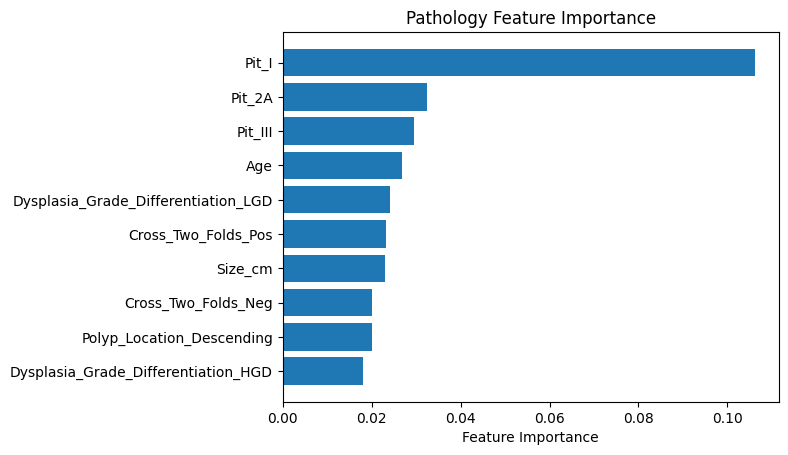

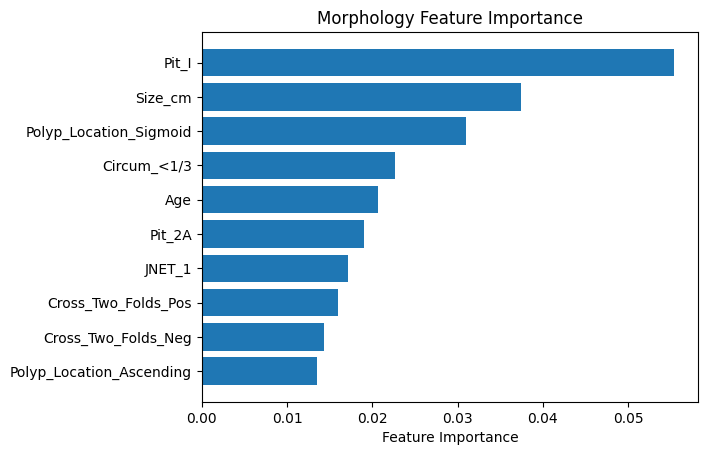

In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Step 1: Prepare the Data

# Extract all Diagnosis columns for Pathology classification
diagnosis_columns = [
    col for col in train_data.columns if col.startswith('Diagnosis_')
]

# Extract all Paris columns for Morphology classification
paris_columns = [
    col for col in train_data.columns if col.startswith('Paris_')
]

# Combine Diagnosis columns into a single target for pathology classification
train_data['Pathology_Target'] = train_data[diagnosis_columns].idxmax(axis=1)
test_data['Pathology_Target'] = test_data[diagnosis_columns].idxmax(axis=1)
val_data['Pathology_Target'] = val_data[diagnosis_columns].idxmax(axis=1)

# Combine Paris columns into a single target for morphology classification
train_data['Morphology_Target'] = train_data[paris_columns].idxmax(axis=1)
test_data['Morphology_Target'] = test_data[paris_columns].idxmax(axis=1)
val_data['Morphology_Target'] = val_data[paris_columns].idxmax(axis=1)

# Features for the model (excluding target columns, unrelated columns, and Patient_ID)
feature_columns = [
    col for col in train_data.columns if col not in
    (['Pathology_Target', 'Morphology_Target', 'File_Path', 'Split', 'Patient_ID', 'Recurrence'] + diagnosis_columns + paris_columns)
]

# Prepare metadata feature sets
X_train_metadata = train_data[feature_columns]
X_test_metadata = test_data[feature_columns]
X_val_metadata = val_data[feature_columns]

# Prepare targets
y_path_train = train_data['Pathology_Target']
y_path_test = test_data['Pathology_Target']
y_path_val = val_data['Pathology_Target']

y_morph_train = train_data['Morphology_Target']
y_morph_test = test_data['Morphology_Target']
y_morph_val = val_data['Morphology_Target']

# Combine metadata features and image features
X_train_combined = np.hstack([X_train_metadata.values, train_image_features_array])
X_test_combined = np.hstack([X_test_metadata.values, test_image_features_array])
X_val_combined = np.hstack([X_val_metadata.values, val_image_features_array])

# Step 2: Train the Models
# Pathology Classification Model
pathology_model = RandomForestClassifier(random_state=42)
pathology_model.fit(X_train_combined, y_path_train)

# Morphology Classification Model
morphology_model = RandomForestClassifier(random_state=42)
morphology_model.fit(X_train_combined, y_morph_train)

# Step 3: Evaluate the Models
# Training Accuracy
pathology_train_acc = pathology_model.score(X_train_combined, y_path_train)
morphology_train_acc = morphology_model.score(X_train_combined, y_morph_train)

print("Training Accuracy for Pathology Model:", pathology_train_acc)
print("Training Accuracy for Morphology Model:", morphology_train_acc)

# Test Accuracy and Metrics
# Pathology Classification Evaluation
y_path_pred = pathology_model.predict(X_test_combined)
print("\nPathology Classification Metrics (Test Data):")
print("Accuracy:", accuracy_score(y_path_test, y_path_pred))
print("Classification Report:")
print(classification_report(y_path_test, y_path_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_path_test, y_path_pred))

# Morphology Classification Evaluation
y_morph_pred = morphology_model.predict(X_test_combined)
print("\nMorphology Classification Metrics (Test Data):")
print("Accuracy:", accuracy_score(y_morph_test, y_morph_pred))
print("Classification Report:")
print(classification_report(y_morph_test, y_morph_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_morph_test, y_morph_pred))

# Step 4: Validate the Models on Validation Dataset
# Pathology Validation
y_path_val_pred = pathology_model.predict(X_val_combined)
print("\nPathology Validation Metrics:")
print("Accuracy:", accuracy_score(y_path_val, y_path_val_pred))
print("Classification Report:")
print(classification_report(y_path_val, y_path_val_pred))

# Morphology Validation
y_morph_val_pred = morphology_model.predict(X_val_combined)
print("\nMorphology Validation Metrics:")
print("Accuracy:", accuracy_score(y_morph_val, y_morph_val_pred))
print("Classification Report:")
print(classification_report(y_morph_val, y_morph_val_pred))

# Step 5: Feature Importance Analysis
def plot_feature_importance(model, features, title):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    top_features = [features[i] for i in sorted_idx[:10]]
    top_importance = importance[sorted_idx[:10]]

    plt.barh(top_features, top_importance)
    plt.xlabel("Feature Importance")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Feature importance for pathology classification
combined_features = list(X_train_metadata.columns) + [f"Image_Feature_{i}" for i in range(train_image_features_array.shape[1])]
plot_feature_importance(pathology_model, combined_features, "Pathology Feature Importance")

# Feature importance for morphology classification
plot_feature_importance(morphology_model, combined_features, "Morphology Feature Importance")


Training Accuracy for Pathology Model: 1.0
Training Accuracy for Morphology Model: 1.0

Pathology Classification Metrics (Test Data):
Accuracy: 0.9905163329820864
Classification Report:
                          precision    recall  f1-score   support

Diagnosis_Adenocarcinoma       1.00      0.92      0.96        24
  Diagnosis_Hyperplastic       1.00      1.00      1.00       491
      Diagnosis_Serrated       1.00      1.00      1.00        13
         Diagnosis_T + V       0.97      1.00      0.98       282
       Diagnosis_Tubular       1.00      0.89      0.94        62
       Diagnosis_Villous       1.00      1.00      1.00        77

                accuracy                           0.99       949
               macro avg       0.99      0.97      0.98       949
            weighted avg       0.99      0.99      0.99       949

Confusion Matrix:
[[ 22   0   0   2   0   0]
 [  0 491   0   0   0   0]
 [  0   0  13   0   0   0]
 [  0   0   0 282   0   0]
 [  0   0   0   7  55   0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

                   precision    recall  f1-score   support

      Paris_0-IIa       1.00      0.98      0.99        63
Paris_0-IIa + IIc       1.00      0.90      0.95        10
 Paris_0-IIa + Is       1.00      0.91      0.95        23
       Paris_0-Ip       0.00      0.00      0.00         3
      Paris_0-Ips       0.96      0.97      0.96       135
       Paris_0-Is       0.98      0.99      0.98       275
      Paris_0-lps       1.00      0.64      0.78        56
       Paris_0-ls       0.95      1.00      0.97       379

         accuracy                           0.96       944
        macro avg       0.86      0.80      0.82       944
     weighted avg       0.96      0.96      0.96       944



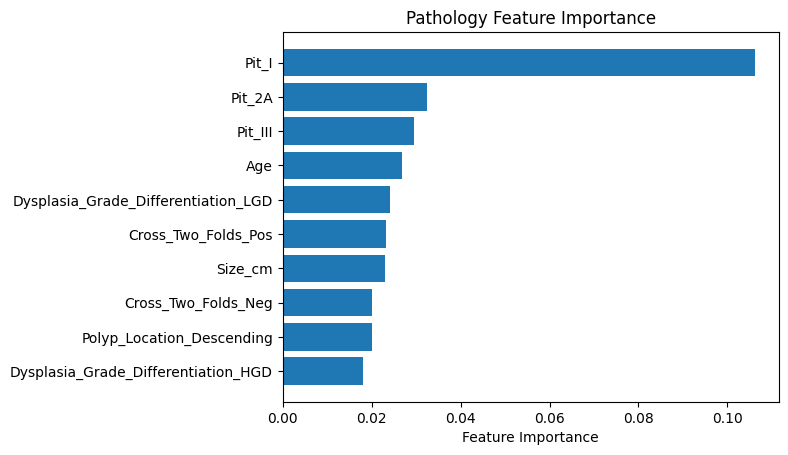

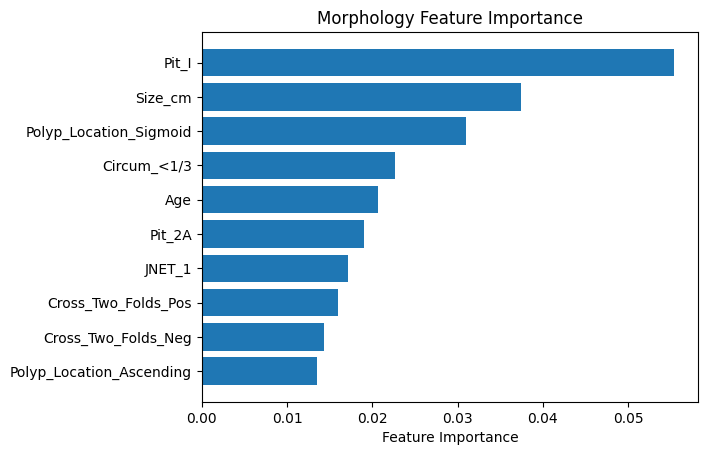

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Step 1: Prepare the Data

# Extract all Diagnosis columns for Pathology classification
diagnosis_columns = [
    col for col in train_data.columns if col.startswith('Diagnosis_')
]

# Extract all Paris columns for Morphology classification
paris_columns = [
    col for col in train_data.columns if col.startswith('Paris_')
]

# Combine Diagnosis columns into a single target for pathology classification
train_data['Pathology_Target'] = train_data[diagnosis_columns].idxmax(axis=1)
test_data['Pathology_Target'] = test_data[diagnosis_columns].idxmax(axis=1)
val_data['Pathology_Target'] = val_data[diagnosis_columns].idxmax(axis=1)

# Combine Paris columns into a single target for morphology classification
train_data['Morphology_Target'] = train_data[paris_columns].idxmax(axis=1)
test_data['Morphology_Target'] = test_data[paris_columns].idxmax(axis=1)
val_data['Morphology_Target'] = val_data[paris_columns].idxmax(axis=1)

# Features for the model (excluding target columns, unrelated columns, and Patient_ID)
feature_columns = [
    col for col in train_data.columns if col not in
    (['Pathology_Target', 'Morphology_Target', 'File_Path', 'Split', 'Patient_ID', 'Recurrence'] + diagnosis_columns + paris_columns)
]

# Prepare metadata feature sets
X_train_metadata = train_data[feature_columns]
X_test_metadata = test_data[feature_columns]
X_val_metadata = val_data[feature_columns]

# Prepare targets
y_path_train = train_data['Pathology_Target']
y_path_test = test_data['Pathology_Target']
y_path_val = val_data['Pathology_Target']

y_morph_train = train_data['Morphology_Target']
y_morph_test = test_data['Morphology_Target']
y_morph_val = val_data['Morphology_Target']

# Combine metadata features and image features
X_train_combined = np.hstack([X_train_metadata.values, train_image_features_array])
X_test_combined = np.hstack([X_test_metadata.values, test_image_features_array])
X_val_combined = np.hstack([X_val_metadata.values, val_image_features_array])

# Step 2: Train the Models
# Pathology Classification Model
pathology_model = RandomForestClassifier(random_state=42)
pathology_model.fit(X_train_combined, y_path_train)

# Morphology Classification Model
morphology_model = RandomForestClassifier(random_state=42)
morphology_model.fit(X_train_combined, y_morph_train)

# Step 3: Evaluate the Models
# Training Accuracy
pathology_train_acc = pathology_model.score(X_train_combined, y_path_train)
morphology_train_acc = morphology_model.score(X_train_combined, y_morph_train)

print("Training Accuracy for Pathology Model:", pathology_train_acc)
print("Training Accuracy for Morphology Model:", morphology_train_acc)

# Test Accuracy and Metrics
# Pathology Classification Evaluation
y_path_pred = pathology_model.predict(X_test_combined)
print("\nPathology Classification Metrics (Test Data):")
print("Accuracy:", accuracy_score(y_path_test, y_path_pred))
print("Classification Report:")
print(classification_report(y_path_test, y_path_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_path_test, y_path_pred))

# Morphology Classification Evaluation
y_morph_pred = morphology_model.predict(X_test_combined)
print("\nMorphology Classification Metrics (Test Data):")
print("Accuracy:", accuracy_score(y_morph_test, y_morph_pred))
print("Classification Report:")
print(classification_report(y_morph_test, y_morph_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_morph_test, y_morph_pred))

# Step 4: Validate the Models on Validation Dataset
# Pathology Validation
y_path_val_pred = pathology_model.predict(X_val_combined)
print("\nPathology Validation Metrics:")
print("Accuracy:", accuracy_score(y_path_val, y_path_val_pred))
print("Classification Report:")
print(classification_report(y_path_val, y_path_val_pred))

# Morphology Validation
y_morph_val_pred = morphology_model.predict(X_val_combined)
print("\nMorphology Validation Metrics:")
print("Accuracy:", accuracy_score(y_morph_val, y_morph_val_pred))
print("Classification Report:")
print(classification_report(y_morph_val, y_morph_val_pred))

# Step 5: Feature Importance Analysis
def plot_feature_importance(model, features, title):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    top_features = [features[i] for i in sorted_idx[:10]]
    top_importance = importance[sorted_idx[:10]]

    plt.barh(top_features, top_importance)
    plt.xlabel("Feature Importance")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Feature importance for pathology classification
combined_features = list(X_train_metadata.columns) + [f"Image_Feature_{i}" for i in range(train_image_features_array.shape[1])]
plot_feature_importance(pathology_model, combined_features, "Pathology Feature Importance")

# Feature importance for morphology classification
plot_feature_importance(morphology_model, combined_features, "Morphology Feature Importance")



Pathology Classification Metrics (Test Data):
Accuracy: 0.9905163329820864
Classification Report:
                          precision    recall  f1-score   support

Diagnosis_Adenocarcinoma       1.00      0.92      0.96        24
  Diagnosis_Hyperplastic       1.00      1.00      1.00       491
      Diagnosis_Serrated       1.00      1.00      1.00        13
         Diagnosis_T + V       0.97      1.00      0.98       282
       Diagnosis_Tubular       1.00      0.89      0.94        62
       Diagnosis_Villous       1.00      1.00      1.00        77

                accuracy                           0.99       949
               macro avg       0.99      0.97      0.98       949
            weighted avg       0.99      0.99      0.99       949



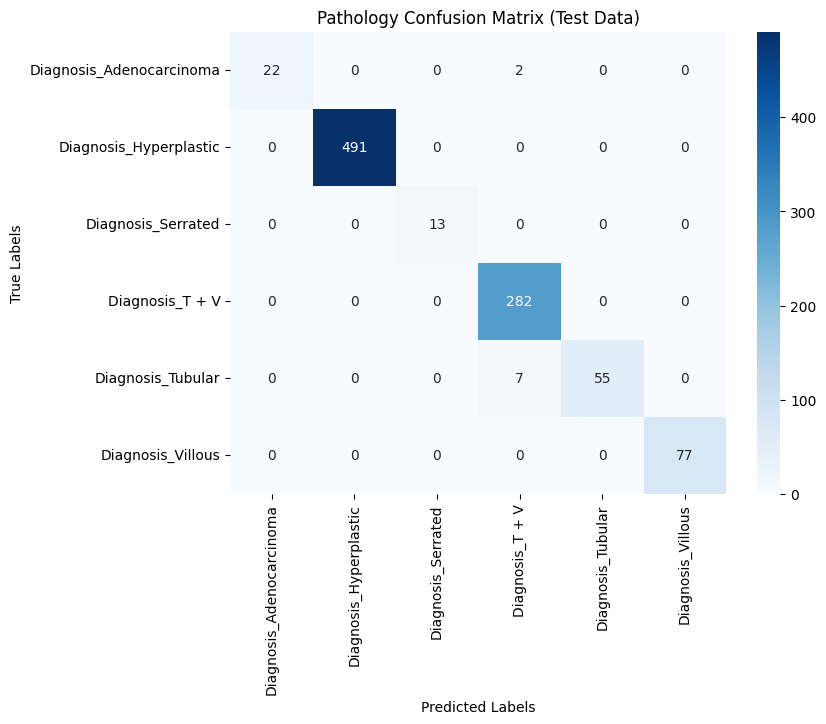


Morphology Classification Metrics (Test Data):
Accuracy: 0.9494204425711275
Classification Report:
                   precision    recall  f1-score   support

      Paris_0-IIa       0.94      0.94      0.94        47
Paris_0-IIa + IIc       1.00      0.89      0.94        18
 Paris_0-IIa + Is       1.00      0.86      0.92        28
       Paris_0-Ip       0.00      0.00      0.00         9
      Paris_0-Ips       0.95      0.98      0.96       166
       Paris_0-Is       0.96      1.00      0.98       285
      Paris_0-lps       1.00      0.57      0.72        60
       Paris_0-ls       0.93      1.00      0.96       336

         accuracy                           0.95       949
        macro avg       0.85      0.78      0.80       949
     weighted avg       0.94      0.95      0.94       949



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


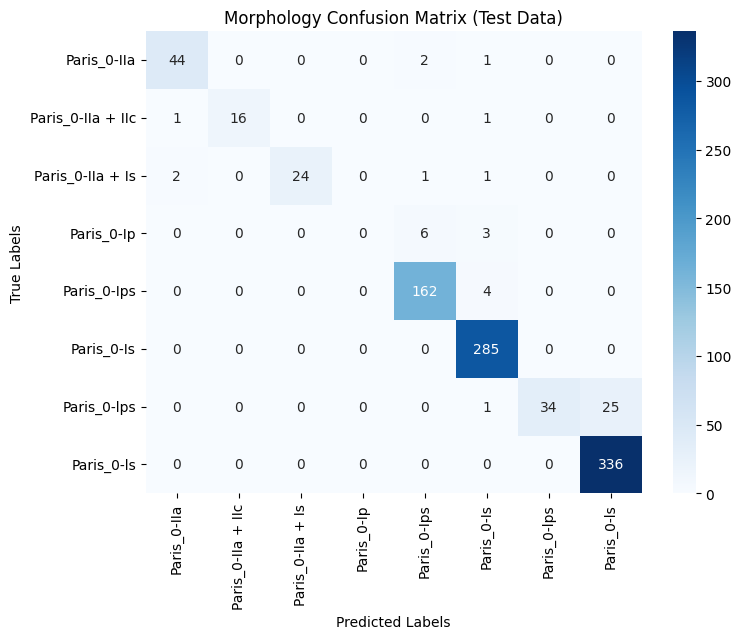


Pathology Validation Metrics:
Accuracy: 0.9819915254237288
Classification Report:
                                  precision    recall  f1-score   support

        Diagnosis_Adenocarcinoma       1.00      0.89      0.94        19
          Diagnosis_Hyperplastic       0.99      1.00      1.00       519
              Diagnosis_Serrated       1.00      0.95      0.98        21
Diagnosis_Serrated, Hyperplastic       0.00      0.00      0.00         1
                 Diagnosis_T + V       0.95      1.00      0.98       242
               Diagnosis_Tubular       0.98      0.82      0.90        68
               Diagnosis_Villous       0.99      1.00      0.99        74

                        accuracy                           0.98       944
                       macro avg       0.85      0.81      0.83       944
                    weighted avg       0.98      0.98      0.98       944



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


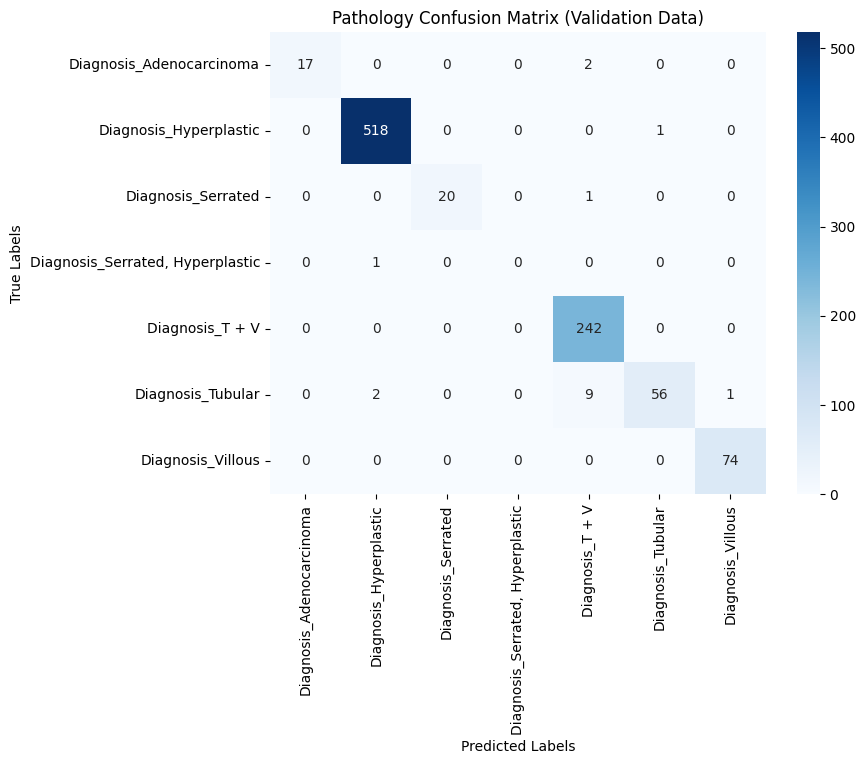


Morphology Validation Metrics:
Accuracy: 0.9639830508474576
Classification Report:
                   precision    recall  f1-score   support

      Paris_0-IIa       1.00      0.98      0.99        63
Paris_0-IIa + IIc       1.00      0.90      0.95        10
 Paris_0-IIa + Is       1.00      0.91      0.95        23
       Paris_0-Ip       0.00      0.00      0.00         3
      Paris_0-Ips       0.96      0.97      0.96       135
       Paris_0-Is       0.98      0.99      0.98       275
      Paris_0-lps       1.00      0.64      0.78        56
       Paris_0-ls       0.95      1.00      0.97       379

         accuracy                           0.96       944
        macro avg       0.86      0.80      0.82       944
     weighted avg       0.96      0.96      0.96       944



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


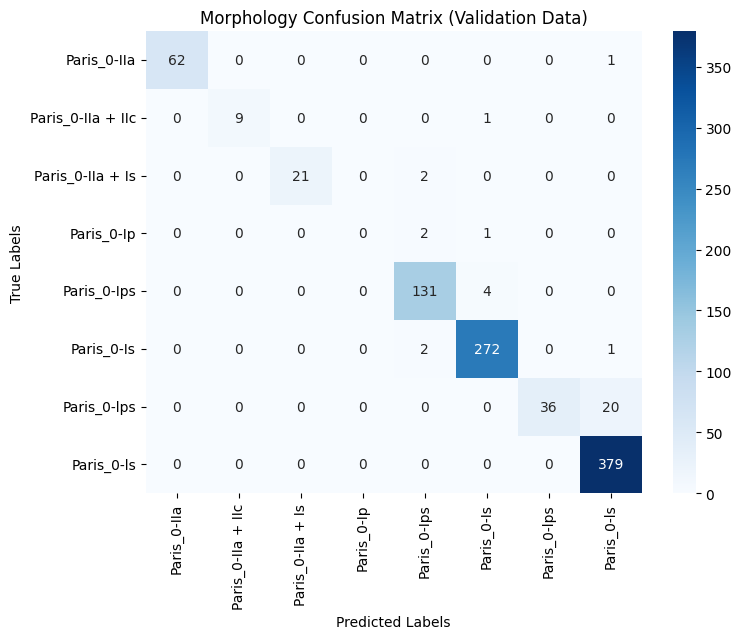

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Step 3: Evaluate the Models with Plots
# Pathology Classification Evaluation
y_path_pred = pathology_model.predict(X_test_combined)
print("\nPathology Classification Metrics (Test Data):")
print("Accuracy:", accuracy_score(y_path_test, y_path_pred))
print("Classification Report:")
print(classification_report(y_path_test, y_path_pred))
plot_confusion_matrix(y_path_test, y_path_pred, "Pathology Confusion Matrix (Test Data)")

# Morphology Classification Evaluation
y_morph_pred = morphology_model.predict(X_test_combined)
print("\nMorphology Classification Metrics (Test Data):")
print("Accuracy:", accuracy_score(y_morph_test, y_morph_pred))
print("Classification Report:")
print(classification_report(y_morph_test, y_morph_pred))
plot_confusion_matrix(y_morph_test, y_morph_pred, "Morphology Confusion Matrix (Test Data)")

# Step 4: Validate the Models with Plots
# Pathology Validation
y_path_val_pred = pathology_model.predict(X_val_combined)
print("\nPathology Validation Metrics:")
print("Accuracy:", accuracy_score(y_path_val, y_path_val_pred))
print("Classification Report:")
print(classification_report(y_path_val, y_path_val_pred))
plot_confusion_matrix(y_path_val, y_path_val_pred, "Pathology Confusion Matrix (Validation Data)")

# Morphology Validation
y_morph_val_pred = morphology_model.predict(X_val_combined)
print("\nMorphology Validation Metrics:")
print("Accuracy:", accuracy_score(y_morph_val, y_morph_val_pred))
print("Classification Report:")
print(classification_report(y_morph_val, y_morph_val_pred))
plot_confusion_matrix(y_morph_val, y_morph_val_pred, "Morphology Confusion Matrix (Validation Data)")


Accuracy on Test Set: 0.9957850368809273
AUC-ROC on Test Set: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       848
           1       1.00      0.96      0.98       101

    accuracy                           1.00       949
   macro avg       1.00      0.98      0.99       949
weighted avg       1.00      1.00      1.00       949



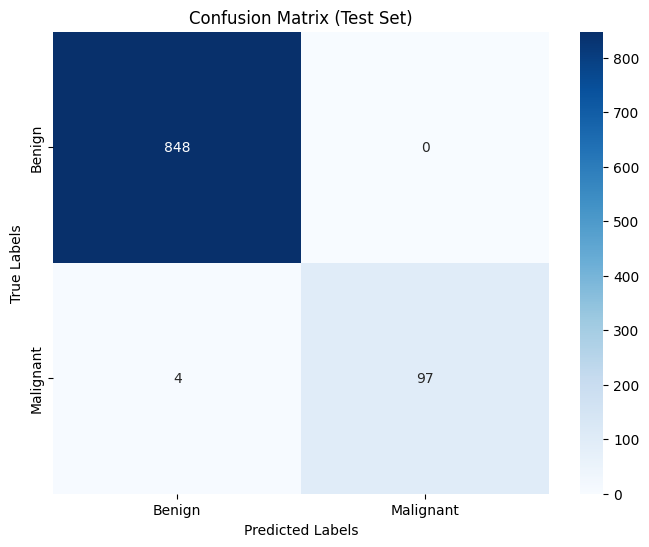

   Malignancy_Probability Predicted_Risk_Level
0                    0.09             Low Risk
1                    0.07             Low Risk
2                    0.07             Low Risk
3                    0.07             Low Risk
4                    0.72            High Risk


In [16]:
# Step 1: Ensure All Features are Numeric
# Perform one-hot encoding on categorical columns, if any
train_data_encoded = pd.get_dummies(train_data, drop_first=True)
test_data_encoded = pd.get_dummies(test_data, drop_first=True)
val_data_encoded = pd.get_dummies(val_data, drop_first=True)

# Align datasets to ensure consistent columns (train/test/val might differ after encoding)
test_data_encoded = test_data_encoded.reindex(columns=train_data_encoded.columns, fill_value=0)
val_data_encoded = val_data_encoded.reindex(columns=train_data_encoded.columns, fill_value=0)

# Step 2: Drop Irrelevant Columns
columns_to_drop = ['Patient_ID', 'Recurrence', 'File_Path', 'Split', 'Risk_Level']
X_train_metadata = train_data_encoded.drop(columns=columns_to_drop + ['Malignancy'], errors='ignore')
X_test_metadata = test_data_encoded.drop(columns=columns_to_drop + ['Malignancy'], errors='ignore')
X_val_metadata = val_data_encoded.drop(columns=columns_to_drop + ['Malignancy'], errors='ignore')

# Step 3: Combine Metadata and Image Features
X_train_combined = np.hstack([X_train_metadata.values, train_image_features_array])
X_test_combined = np.hstack([X_test_metadata.values, test_image_features_array])
X_val_combined = np.hstack([X_val_metadata.values, val_image_features_array])

# Target variable: Malignancy
y_train = train_data['Malignancy']
y_test = test_data['Malignancy']
y_val = val_data['Malignancy']

# Step 4: Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_combined, y_train)

# Step 5: Evaluate the Model
# Predict on test data
y_pred_test = rf_model.predict(X_test_combined)
y_proba_test = rf_model.predict_proba(X_test_combined)[:, 1]

# Test set metrics
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred_test))
print("AUC-ROC on Test Set:", roc_auc_score(y_test, y_proba_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix (Test Set)")

# Step 6: Risk Stratification
# Predict malignancy probabilities for validation data
y_proba_val = rf_model.predict_proba(X_val_combined)[:, 1]

# Assign risk levels based on probabilities
risk_levels = pd.cut(y_proba_val, bins=[0, 0.3, 0.7, 1], labels=["Low Risk", "Moderate Risk", "High Risk"])

# Combine results into a DataFrame
val_results = val_data.copy()
val_results['Malignancy_Probability'] = y_proba_val
val_results['Predicted_Risk_Level'] = risk_levels

# Display the first few results
print(val_results[['Malignancy_Probability', 'Predicted_Risk_Level']].head())


In [17]:
# Step 7: Include Polyp Type in Risk Stratification Results
# Define a function to extract the polyp type based on diagnosis columns
def get_polyp_type(row):
    if row['Diagnosis_Adenocarcinoma'] == 1:
        return "Adenocarcinoma"
    elif row['Diagnosis_Villous'] == 1:
        return "Villous"
    elif row['Diagnosis_Tubular'] == 1:
        return "Tubular"
    elif row['Diagnosis_Hyperplastic'] == 1:
        return "Hyperplastic"
    elif row['Diagnosis_Serrated'] == 1:
        return "Serrated"
    elif row['Diagnosis_Traditional Serrated Adenoma'] == 1:
        return "Traditional Serrated Adenoma"
    elif row['Diagnosis_Serrated, Hyperplastic'] == 1:
        return "Serrated, Hyperplastic"
    elif row['Diagnosis_T + V'] == 1:
        return "T + V"
    else:
        return "Unknown"

# Apply the function to determine polyp type for each sample in the validation set
val_data['Polyp_Type'] = val_data.apply(get_polyp_type, axis=1)

# Add the Polyp_Type to the results DataFrame
val_results['Polyp_Type'] = val_data['Polyp_Type']

# Display the first few results, including Polyp Type
print(val_results[['Malignancy_Probability', 'Predicted_Risk_Level', 'Polyp_Type']].head())


   Malignancy_Probability Predicted_Risk_Level Polyp_Type
0                    0.09             Low Risk      T + V
1                    0.07             Low Risk      T + V
2                    0.07             Low Risk      T + V
3                    0.07             Low Risk      T + V
4                    0.72            High Risk    Villous


In [19]:
# Original min and max values for Age and Size_cm
age_min, age_max = 29, 94
size_min, size_max = 0.3, 5.0

# Function to denormalize values
def denormalize(value, original_min, original_max):
    return value * (original_max - original_min) + original_min

# Overwrite Age and Size_cm with denormalized values in the training dataset
train_data['Age'] = train_data['Age'].apply(lambda x: denormalize(x, age_min, age_max))
train_data['Size_cm'] = train_data['Size_cm'].apply(lambda x: denormalize(x, size_min, size_max))

# Overwrite Age and Size_cm with denormalized values in the validation dataset
val_data['Age'] = val_data['Age'].apply(lambda x: denormalize(x, age_min, age_max))
val_data['Size_cm'] = val_data['Size_cm'].apply(lambda x: denormalize(x, size_min, size_max))

# Overwrite Age and Size_cm with denormalized values in the test dataset
test_data['Age'] = test_data['Age'].apply(lambda x: denormalize(x, age_min, age_max))
test_data['Size_cm'] = test_data['Size_cm'].apply(lambda x: denormalize(x, size_min, size_max))

# Display the first few rows of the train_data to verify
print(train_data[['Age', 'Size_cm']].head())


         Age  Size_cm
0  78.576271      0.5
1  78.576271      0.5
2  78.576271      0.5
3  78.576271      0.5
4  78.576271      0.5


<ipython-input-28-a455e1764250>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_subset['Age_Group'] = pd.cut(train_subset['Age'], bins=age_bins, labels=age_labels)
<ipython-input-28-a455e1764250>:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_polyp_counts = train_subset.groupby('Age_Group')[


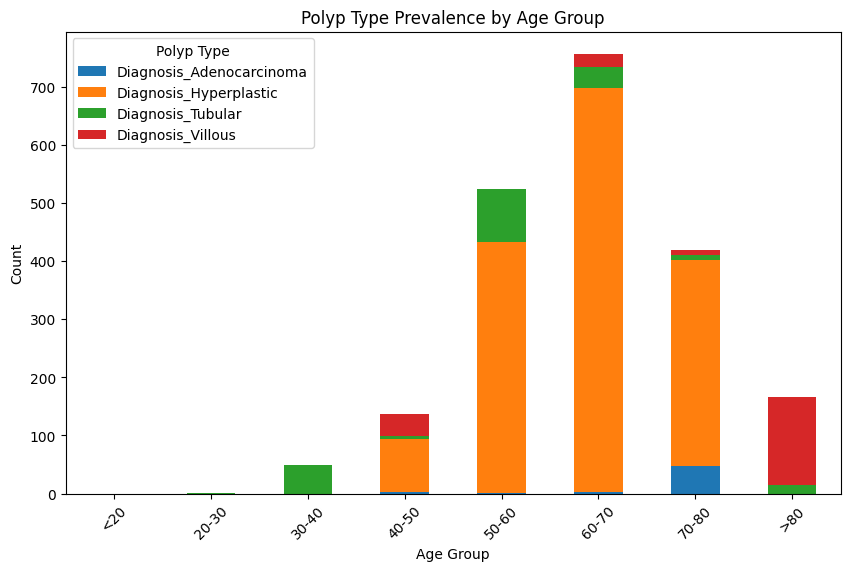

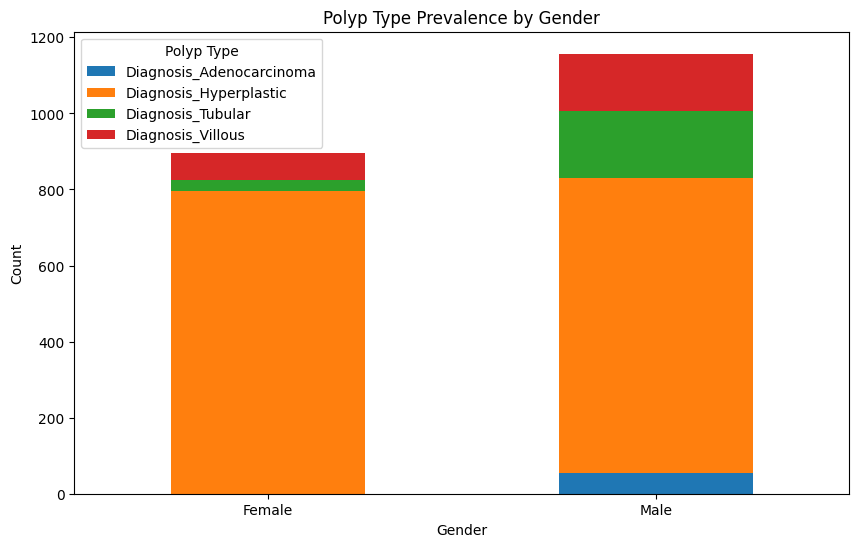

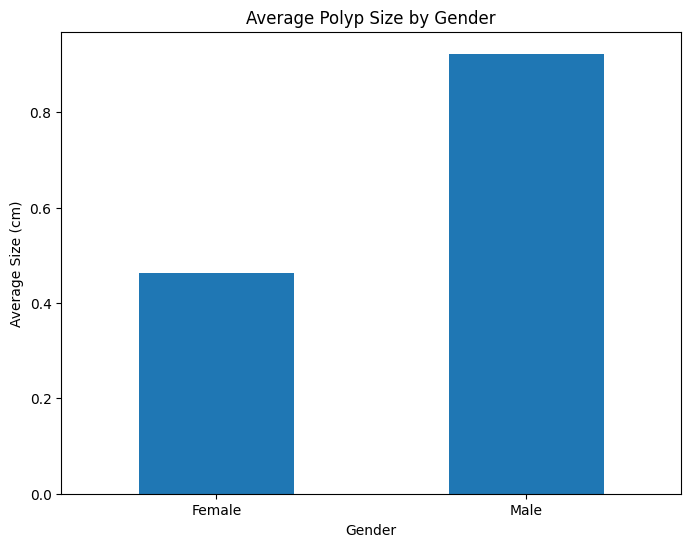

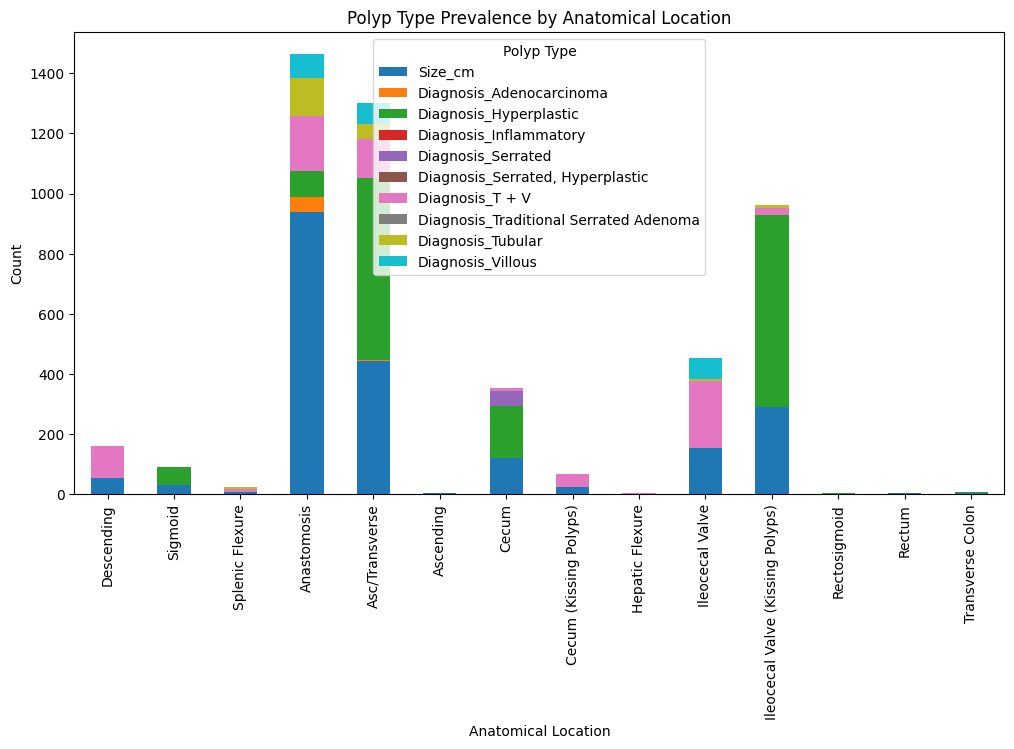

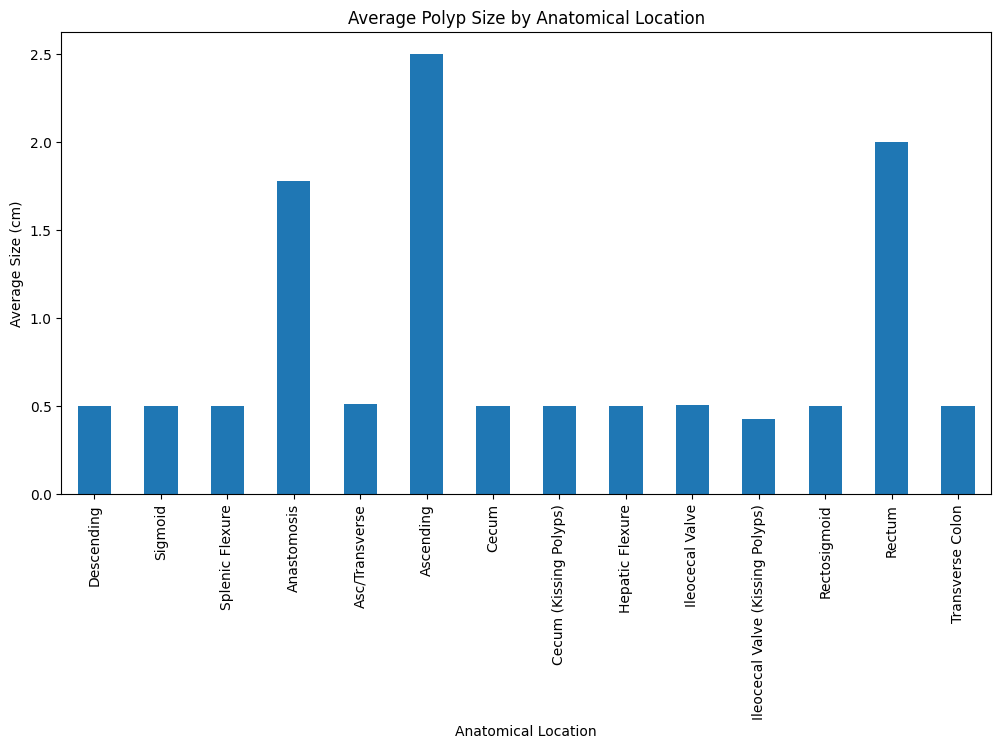

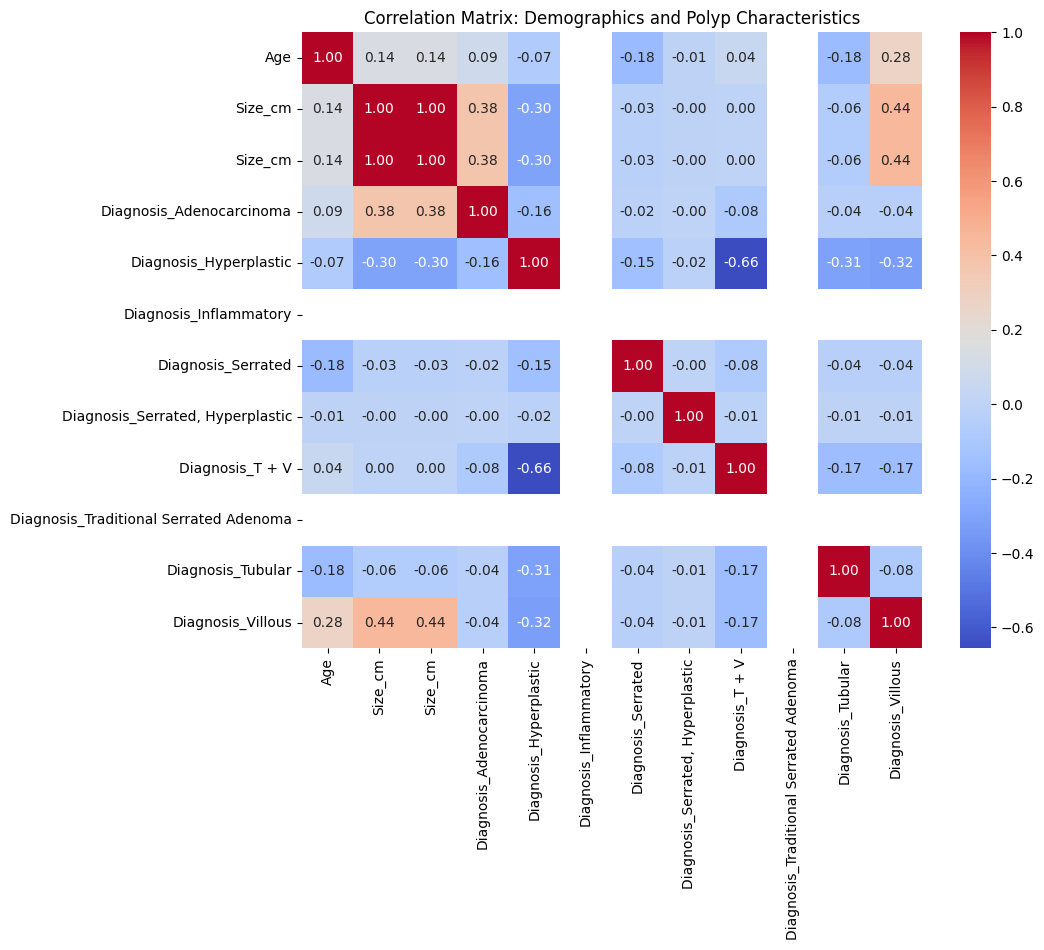

Chi-Square Test Results: Gender vs. Adenocarcinoma
Chi2 Value: 40.14791398270624, p-value: 2.3544276931454003e-10


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Dataset Preparation
# Relevant demographic features
demographic_features = ['Age', 'Sex_F', 'Sex_M']

# Polyp characteristics
polyp_features = [
    'Size_cm', 'Diagnosis_Adenocarcinoma', 'Diagnosis_Hyperplastic',
    'Diagnosis_Inflammatory', 'Diagnosis_Serrated', 'Diagnosis_Serrated, Hyperplastic',
    'Diagnosis_T + V', 'Diagnosis_Traditional Serrated Adenoma',
    'Diagnosis_Tubular', 'Diagnosis_Villous'
]

# Anatomical location columns
location_features = [col for col in train_data.columns if 'Polyp_Location_' in col]

# Combine all features of interest
features_of_interest = demographic_features + polyp_features + location_features

# Filter train, test, and validation datasets
train_subset = train_data[features_of_interest]
test_subset = test_data[features_of_interest]
val_subset = val_data[features_of_interest]

# Step 2: Analyze Age-Based Patterns
# Group ages into bins
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
age_labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '>80']

# Add age bins to the training dataset
train_subset['Age_Group'] = pd.cut(train_subset['Age'], bins=age_bins, labels=age_labels)

# Analyze polyp type prevalence by age group
age_polyp_counts = train_subset.groupby('Age_Group')[
    ['Diagnosis_Adenocarcinoma', 'Diagnosis_Hyperplastic', 'Diagnosis_Tubular', 'Diagnosis_Villous']
].sum()

anatomical_locations = [
    "Descending", "Sigmoid", "Splenic Flexure", "Anastomosis",
    "Asc/Transverse", "Ascending", "Cecum", "Cecum (Kissing Polyps)",
    "Hepatic Flexure", "Ileocecal Valve", "Ileocecal Valve (Kissing Polyps)", "Rectosigmoid",
     "Rectum",
     "Transverse Colon",
]

# Visualize polyp types across age groups
age_polyp_counts.plot(kind='bar', figsize=(10, 6), stacked=True)
plt.title("Polyp Type Prevalence by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Polyp Type")
plt.show()

# Step 3: Analyze Gender-Based Patterns
# Analyze polyp type prevalence by gender
gender_polyp_counts = train_subset.groupby(['Sex_F', 'Sex_M'])[
    ['Diagnosis_Adenocarcinoma', 'Diagnosis_Hyperplastic', 'Diagnosis_Tubular', 'Diagnosis_Villous']
].sum()

# Gender descriptive labels
gender_labels = ['Female', 'Male']

# Replace gender binary labels with descriptive names
gender_polyp_counts.index = gender_labels

# Visualize polyp types by gender
gender_polyp_counts.plot(kind='bar', figsize=(10, 6), stacked=True)
plt.title("Polyp Type Prevalence by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Polyp Type")
plt.show()

# Compare average polyp size by gender
gender_size_avg = train_subset.groupby(['Sex_F', 'Sex_M'])['Size_cm'].mean()

# Replace gender binary labels with descriptive names
gender_size_avg.index = gender_labels

# Visualize average polyp size by gender
gender_size_avg.plot(kind='bar', figsize=(8, 6))
plt.title("Average Polyp Size by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Size (cm)")
plt.xticks(rotation=0)
plt.show()

# Step 4: Analyze Anatomical Location Patterns
# Analyze polyp type prevalence by location
location_polyp_counts = train_subset[location_features + polyp_features].groupby(location_features).sum()

# Replace the default x-axis labels with descriptive names
location_polyp_counts.index = anatomical_locations

# Visualize polyp types across locations
location_polyp_counts.plot(kind='bar', figsize=(12, 6), stacked=True)
plt.title("Polyp Type Prevalence by Anatomical Location")
plt.xlabel("Anatomical Location")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title="Polyp Type")
plt.show()

# Compare average polyp size by location
location_size_avg = train_subset.groupby(location_features)['Size_cm'].mean()

# Replace the default x-axis labels with descriptive names
location_size_avg.index = anatomical_locations

# Visualize average polyp size by location
location_size_avg.plot(kind='bar', figsize=(12, 6))
plt.title("Average Polyp Size by Anatomical Location")
plt.xlabel("Anatomical Location")
plt.ylabel("Average Size (cm)")
plt.xticks(rotation=90)
plt.show()

# Step 5: Statistical Analysis
# Correlation matrix for demographic and polyp characteristics
correlation_matrix = train_subset[['Age', 'Size_cm'] + polyp_features].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Matrix: Demographics and Polyp Characteristics")
plt.show()

# Example: Chi-Square Test for Gender vs. Adenocarcinoma
from scipy.stats import chi2_contingency

# Crosstab for gender and adenocarcinoma diagnosis
contingency_table = pd.crosstab(train_subset['Sex_F'], train_subset['Diagnosis_Adenocarcinoma'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test Results: Gender vs. Adenocarcinoma")
print(f"Chi2 Value: {chi2}, p-value: {p}")
